#Preamble

This mini-project involves working through all the steps of a problem, whereas prior assignments asked you to just implement core functions. We will give you a dataset, but you will also have the opportunity to manipulate the data in ways that you find beneficial to the overall project and to explain why and how those manipulations mattered. This will be in addition to building the model from scratch, developing the training loop, and implementing testing. The code will be accompanied by a report written into the notebook.

This project will have you working with attention mechanism, in a new type of system for question-answering. This will provide you with experience working with attention mechanisms while not directly working with transformers.

This assignment is not autograded. You can modify any code cells as long as you achieve the requirements of each graded component.

# Introduction

Memory networks learn to access external memory stores (a database or, in the case of this assignment, a dictionary). Key-Value Memory Networks specifically assume that the external memory store is organized as a dictionary with keys and values. In theory memory networks are useful when one wants a neural network to be able to know a lot of information but we don't want to try to encode that information directly into the parameters of the network. This means information can be changed in the external memory database without retraining the neural network.

Given a question, e.g., "Where was Alexander Hamilton born?", a key-value memory network learns an embedding such that the question has a high cosine similarity to a particular key in the external dictionary. Because there are many keys that need to be matched against, key-value memory networks implement an attention-scoring mechanism to select a key. Because attention is a probabilistic score, the key-value memory network retrieves a sum of embeddings weighted according to the attention score. This weighted embedding is then compared to values using a second attention-scoring mechanism. The value with the highest cosine similarity can then be retrieved and returned as the answer.

Memory networks were an important part of the evolution of question-answering systems that have been eclipsed by transformers. However, the attention mechanism in a key-value memory network is very similar to the self-attention inside a transformer, so implementing a key-value memory network is a really great way to experiment and learn about self-attention without the added complexity of transformers.

Key-value memory networks are also closely related to retieval-based generation networks, except we will be retrieving facts from a dictionary instead of via the internet. However, the embedding of retrieved data will be similar.

Key-value memory networks are described in this [paper](https://arxiv.org/abs/1606.03126). It is recommended that you read the paper, but we will also walk through the steps you will need to complete.

# Some imports



You may add imports as necessary.

In [ ]:
import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
from IPython.display import Image, display
import re
import os
import json
import random
import numpy as np
import pickle
from tqdm import tqdm
import nltk
from nltk.corpus import stopwords
import matplotlib.pyplot as plt

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

Unidecode is useful for getting rid of issues that arise from unicode. This should not be used if we care about unicode, but for the purposes of an instructional exercise, it eliminates a lot of edge cases that come up with unicode.

In [3]:
!pip install unidecode

Defaulting to user installation because normal site-packages is not writeable



[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: C:\Users\mccar\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [4]:
import unidecode

If you need to have a reduced vocabulary, you can create an unknown "unk" token and add it to the vocabulary. Make sure the token index in the vocabulary and `UNK_ID` match.

In [5]:
UNK = 'unk'
UNK_ID = '0'

# Some utilities

You may edit these as necessary.

Stem words

In [6]:
# Stemming the text
def simple_stemmer(text):
    ps=nltk.porter.PorterStemmer()
    text= [ps.stem(word) for word in text]
    return text

Simple tokenizer that only keeps letters and numbers.

In [7]:
def tokenize(line):
    line = re.sub(r'[^a-zA-Z0-9]', ' ', unidecode.unidecode(line)) # remove punctuation
    line = line.lower().split()  # lower case
    return line

A standard vocabulary object class

In [8]:
class Vocab:
    def __init__(self, name = 'vocab'):
        self.name = name
        self._word2index = {}
        self._word2count = {}
        self._index2word = {}
        self._n_words = 0

    def get_words(self):
      return list(self._word2count.keys())

    def num_words(self):
      return self._n_words

    def word2index(self, word):
      return self._word2index[word]

    def index2word(self, word):
      return self._index2word[word]

    def word2count(self, word):
      return self._word2count[word]

    def add_sentence(self, sentence):
        for word in tokenize(sentence):
            self.add_word(word)

    def add_word(self, word):
        if word not in self._word2index:
            self._word2index[word] = self._n_words
            self._word2count[word] = 1
            self._index2word[self._n_words] = word
            self._n_words += 1
        else:
            self._word2count[word] += 1

Make a bag of words frmo a sentence, given a vocabulary. Can return a bag of word counts or a a bag of word presences.

In [9]:
def multihot(s, vocab, preserve_counts = False):
  tokens = np.array([vocab.word2index(t) for t in tokenize(s)])
  mhot = np.zeros((tokens.size, vocab.num_words()))
  mhot[np.arange(tokens.size), tokens] = 1
  if preserve_counts:
    return mhot.sum(0)
  else:
    return mhot.sum(0) >= 1


If you have a reduced vocabulary, use this to replace out-of-vocab words. If you use this, you may want to merge it with `multihot` above to avoid tokenizing twice.

In [10]:
def unkit(s, vocab):
  return ' '.join(list(map(lambda x: UNK if x not in vocab._word2index else x, tokenize(s))))

# Part A: Download and Process Data (0 points)

This dataset contains the information in tables that are commonly used in Wikipedia biography pages. Each person has different rows of information pertaining to their notable accomplishments and details about their life. There are a large number of types of information that can appear as rows in the biography tables, however they are relatively uniform. We call the keys of the rows "relations".

For example [Alexander Hamilton](https://en.wikipedia.org/wiki/Alexander_Hamilton) has information about the President he worked for as Secretary of State, birth date, date of death, parents' names, etc.

The code below will download the dataset and process it to create two things:
- `DB`: a hash table that map titles of biography wikipedia articles to table information. The table information is represented as a nested hash table containing relations as keys, and associated values. For example, `DB['alexander hamilton'] = {'party': 'federalist',
 'spouse': 'elizabeth schuyler', ...}`
- `VOCAB`: A vocabulary object that maps words to tokens and vice versa.

In [11]:
!git clone https://github.com/rlebret/wikipedia-biography-dataset.git

fatal: destination path 'wikipedia-biography-dataset' already exists and is not an empty directory.


In [12]:
# !cat wikipedia-biography-dataset/wikipedia-biography-dataset.z?? > tmp.zip
# !unzip -o tmp.zip
# !rm tmp.zip

# edting htis shiz so it works on windows
!copy /b wikipedia-biography-dataset\wikipedia-biography-dataset.z?? tmp.zip
!tar -xf tmp.zip
!del tmp.zip

wikipedia-biography-dataset\wikipedia-biography-dataset.z00
wikipedia-biography-dataset\wikipedia-biography-dataset.z01
wikipedia-biography-dataset\wikipedia-biography-dataset.z02
wikipedia-biography-dataset\wikipedia-biography-dataset.z03
wikipedia-biography-dataset\wikipedia-biography-dataset.z04
wikipedia-biography-dataset\wikipedia-biography-dataset.z05
wikipedia-biography-dataset\wikipedia-biography-dataset.z06
wikipedia-biography-dataset\wikipedia-biography-dataset.z07
wikipedia-biography-dataset\wikipedia-biography-dataset.z08
wikipedia-biography-dataset\wikipedia-biography-dataset.z09
wikipedia-biography-dataset\wikipedia-biography-dataset.z10
wikipedia-biography-dataset\wikipedia-biography-dataset.z11
wikipedia-biography-dataset\wikipedia-biography-dataset.z12
wikipedia-biography-dataset\wikipedia-biography-dataset.z13
wikipedia-biography-dataset\wikipedia-biography-dataset.z14
wikipedia-biography-dataset\wikipedia-biography-dataset.z15
        1 file(s) copied.


Get all the wikipedia titles.

In [13]:
train_titles = []
with open("wikipedia-biography-dataset/train/train.title", "r", encoding="utf-8") as file:
  for line in file:
    train_titles.append(line.rstrip())

Boxes contain all the information, with each line corresponding to a title in `titles`.

In [14]:
train_boxes = []
with open("wikipedia-biography-dataset/train/train.box", "r", encoding="utf-8") as file:
  for line in file:
    train_boxes.append(line.rstrip())

This will make the DB object, a dictionary of dictionaries for each wikipedia title, which is more or less the same as names. This function only keeps politicians (containing the "office" key term) and strips out information about images. It can be improved in many ways.

In [15]:
# Make a dictionary of dictionaries
def make_db(titles, boxes):
  db = {} # The DB
  # Iterate through titles
  for i in tqdm(range(len(titles))):
    box = boxes[i] # Grab the corresponding box information
    d  = {} # Inner dictionary
    # Build a dict for the ith entry
    # grab each key:value pair
    for pair in re.findall(r'([a-zA-Z_]+)[0-9]*\:([\w\d]+)', box):
      key, value = pair
      # Do a bit of cleaning
      key = key.strip()
      value = value.strip()
      # If the key contains the word image, we probably don't want to keep it
      if 'image' not in key:
        # The regex maintains underscores, strip those off
        if key[-1] == '_':
          key = key[:-1]
        # Make a new entry in inner dictionary if we don't have one
        if key not in d:
          d[key] = value
        # Keys with compound values are split up, which is annoying, so put them back together
        else:
          d[key] += ' ' + value
    # If it has an office key, keep it.
    if 'office' in d:
      db[titles[i]] = d
  return db

Build the vocab from the DB. Convert the whole thing into a string, tokenize it, and feed the surviving words into the vocab.

In [16]:
def make_vocab(DB):
  # Make the vocab object
  vocab = Vocab()
  # Tokenize the data by converting the entire DB into a string
  tokens = tokenize(str(DB))
  # Iterate through all the tokens (tqdm provides a progress bar)
  for t in tqdm(tokens):
    vocab.add_word(t)
  return vocab

If you want to discard rare words, this will rebuild the vocab. This is just an example.

In [17]:
def reduce_vocab(vocab, min_word_occurrence = 2):
  # make a new vocab
  vocab2 = Vocab("top")
  # Add the UNK token
  vocab2.add_word(UNK)
  # Iterate through vocabulary
  for w in list(vocab._word2count.keys()):
    count = vocab._word2count[w]
    idx = vocab._word2index[w]
    # If the word count passes threshold, add it to the new vocabulary object
    if count >= min_word_occurrence:
      vocab2.add_word(w)
      vocab2._word2count[w] = count
  # Return the new vocabulary object
  return vocab2

Make the DB

In [18]:
DB = make_db(train_titles, train_boxes)

100%|██████████| 582659/582659 [00:46<00:00, 12646.65it/s]


Make the VOCAB

In [19]:
VOCAB = make_vocab(DB)
print(VOCAB.num_words())

100%|██████████| 2997937/2997937 [00:01<00:00, 2080230.52it/s]

96093


## Save Processed Data

You may find it useful to save the processed dataset to your Google Drive.

It is recommended that you save the file to your Google Drive. To mount your Google Drive, open the file icon on the left side of the screen to get to the option). To save the file in your Google Drive use the path `'drive/MyDrive/filename'`.)

In [20]:
# from google.colab import drive
# drive.mount('/content/drive')

In [21]:
# with open("drive/MyDrive/data", "wb") as f:
#   pickle.dump(DB, f, protocol=None, fix_imports=True, buffer_callback=None)

In [22]:
# with open('drive/MyDrive/vocab', 'wb') as f:
#     pickle.dump(VOCAB, f, protocol=None, fix_imports=True, buffer_callback=None)

## Load processed data

If you have saved the processed data in your Google Drive, you can re-load it with these commands.

In [23]:
# with open("drive/MyDrive/vocab", "rb") as f:
#   VOCAB = pickle.load(f)

In [24]:
# with open("drive/MyDrive/data", "rb") as f:
#   DB = pickle.load(f)

## Data example

Get to know your data.

In [25]:
DB["alexander hamilton"]

{'name': 'alexander hamilton',
 'office': '1st united states secretary of the treasury senior officer of the army delegate to the congress of the confederation from new york',
 'president': 'george washington john adams',
 'term_start': 'september 11 1789 december 14 1799 november 3 1788 november 4 1782',
 'term_end': 'january 31 1795 june 15 1800 march 2 1789 june 21 1783',
 'predecessor': 'position established george washington egbert benson seat established',
 'successor': 'oliver wolcott jr james wilkinson seat abolished seat abolished',
 'birth_date': '11 january 1755',
 'birth_place': 'charlestown nevis british west indies',
 'death_date': 'july 12 1804 aged 47 or 49',
 'death_place': 'new york city new york u',
 'party': 'federalist',
 'spouse': 'elizabeth schuyler',
 'children': 'philip angelica alexander james alexander john church william stephen eliza holly phil',
 'alma_mater': 'kings college new york',
 'religion': 'presbyterian episcopalian convert',
 'signature': 'alexan

# Part B: Implement the Key-Value Memory Network (10 points)

This [paper](https://arxiv.org/abs/1606.03126) describes the key-value memory networks in detail, which is also sketched out below.

A key-value memory network takes a natural language question. This question will be converted into a bag-of-words (i.e., a multihot) Call this $x$ and it is a 1D tensor of vocabulary length.

![KVMemNet architecture](https://github.com/markriedl/kvmemnet-assignment/blob/32479dd1e88a9f8dfc72f11ccb8e9e0e1f78905f/kvmemnet-inside.png?raw=true)

The KVMemNet will contain a linear layer (or embedding layer) that will produce a 1D embedding of the question $q=A(x)$.

The KVMemNet will also take in a stack of keys as a tensor of shape `num_keys x vocab_size`. Each row is embedded using the same embedding, $k=A(keys)$, producing a tensor of shape `num_keys x embed_dim`. How this stack of keys is chosen will be discussed below.

The KVMemNet will take in a third input, a stack of values associated with the stack of keys. This will also be of shape `num_values x vocab_size`. Each row is embedded using the same embedding, $v=A(values)$, producing a tensor of shape `num_keys x embed_dim`.

The KVMemNet will also contain a second linear embedding layer, $B$. More on this later.

Once we have `q`, `k`, and `v` embeddings, the next step is to use `q` and `k` to compute attention scores that can be applied against `v`. Think of $A$ as learning how to make questions and the keys that should match against values that have received the same treatment.

The attention scores `p` are computed by taking the inner-product (`torch.inner()`) between `q` and `k`. The result will be a 1D tensor with `num_keys` length. Use softmax so that `p` contains scores between 1.0 and 0.0.

You may be wondering why there isn't a non-linearity such as a sigmoid or ReLU after the linear layer. Softmax is a non-linearity.

Next apply the `p` attention scores against `v` to apply a weight against each value in the stack of values. One should be highly weighted and the rest less weighted. Sum all the weighted values up to create a 1D tensor `o` of feature weights of length `embed_dim`. `p` can be thought of as how much of each value gets selected. Then they all get combined together and the feature weights are proportional to how much each value was attended to. The `torch.matmul()` can do the multiplication and summing in one step.

The KVMemNet forward function should return this tensor of feature weights `o`.

A quick note on `k` and `v`. We can't send the entire set of keys and values in our database through the network's forward function. Instead there should be a selection mechanism that selects just a subset of the database. This subset should contain the best key for the question $x$ to match against, and its corresponding value. We assume that a shallow selection process can narrow down the key-value pairs to a relatively small set, one of which will be best. For example, if the question involves "Alexander Hamilton", we can reasonably guess that the best key-value pair is in the part of the database associated with the named person.

We are not done though. What about our linear layer $B$? Suppose variable `Y` contains our entire set of values in our databse as bags of words. $B$ is going to be used to embed our entire set of database values $y=B(Y)$. $B$ can be thought of as learning how to make all the values look like the feature weights output by the model such that the highest cosine similarity corresponds to the correct value taken from *all* values in the database.

$B$ should live inside the KVMemNet object so that its parameters become trainable, but notice that we do not use $B$ in the KVMemNet's forward function. $B$ will get used to prepare the stack of all values in the database for training. It will bet used in the training loop but outside of the forward function. This is a bit unusual, but necessary to figure out the correct target (the true index of the best value to match against) for training.

The above explantion only implements *single-hop* retrieval. *multi-hop* retrieval allows the results of one retrieval to inform a second (and third and so on) to get the right retrieval. This would be used in the case where the answer cannot be inferred directly from the question in a single retrieval, such as "What was the founding date of the country that Alexander Hamilton was born in?". To implement multi-hop retrieval, the KVMemNet will have additional linear layers $R_1...R_n$. Each $R_{i}$ will do a linear transform on `q` then attention will score and retrieve values as feature weights `o`. This will be sent to the next $R_{i+1}$ and so on until the hops are complete. This final `o` will be returned.

For this assignment is is sufficient to only do *single-hop* retrieval.

The above explanation does not include consideration of batching. You may want to add a batch dimension as the first dimension and input a batch as a set of questions, a set of stacks of keys, and a set of stacks of values. To do this, functions like `.inner()`, `.mm()`, and`.matmul()` will not work. Instead use `.bmm()` which handles batching correctly. You will probably need to do some `.squeeze()` and `.unsqueeze()` operations to make sure your tensors are the correct shapes.

Instead of bag-of-words, one may also consider first converting each question, key, and value into a general set of embeddings such as [GLoVe](https://nlp.stanford.edu/projects/glove/). To do this one will need to consider how to combine words--convert each word into an embedding vector and then add the vectors together (or maybe average them).

**Complete the key-value memory net code**

In [26]:
class KVMemNet(nn.Module):
  def __init__(self, vocab_size, embed_dim):
    super(KVMemNet, self).__init__()
    self.vocab_size = vocab_size
    self.embed_dim = embed_dim
    ### YOUR CODE HERE
    # ok so here we go
    # so the first layer, layer a embeds the questions and kyes and values
    # the second layer, layer b, embeds the db vals for comp
    # standard stuff here, shouldnt be anything crazy
    self.a_layer1 = nn.Linear(vocab_size, embed_dim)
    self.b_layer1 = nn.Linear(vocab_size, embed_dim)

  def forward(self, x, keys, values):
    output = None
    ### YOUR CODE BELOW
    # So here is where we get cooking
    # embedding the question, the keys, and the values
    # this looks weird pushing them all t the same layer but 
    ques_embs = self.a_layer1(x)
    key_embs = self.a_layer1(keys)
    val_embs = self.a_layer1(values)

    # notice we DO NOT use layer b here, it will be in the training loop
    # later as mentioned in the instructions
    
    # Compute attn scores here
    # inner product between q and each key
    # just an nner prod here of the embeddings
    # softmax the output
    # and then Apply the attn weights, agan a matmul
    # This is all from previous projs
    matprod = torch.inner(ques_embs, key_embs)
    matprod = F.softmax(matprod, dim=0)
    o = torch.matmul(matprod, val_embs)
    # forgot the key word again
    output = o

    ### YOUR CODE ABOVE
    return output


# Synthetic Data Set

This is a synthetic dataset. One way to test a model during development is to take a small piece of data and show that you can overfit a model. If you can't overfit an easily learned chunk of data, then you probably have something wrong in your code. In this case I have provided a small chunk of synthetic data that should be easy to learn.

- The vocabulary is 20 word: 5 names, 5 relations, 5 question-words, 5 values
 - First 5 elements of the vocab are names (for example index 0 might be "Hamilton").
 - Second 5 elements of the vocab are relations (for example, "born", "died", "occupation").
 - Third 5 elements are random words that might be part of a query (for example, "When was").
 - Final 5 elements of the vocab are possible values (for example, "1757")
- A "question" is a name (5, 1), relation (5, 1), some words (5, 1), and no values
- The keys will all have the same name (5, 5) where each row is idential, relations (5, 5), no words, no values
- Values will have no names, no relations, no words, and value vocab words

In [27]:
# Turn on a different relation on each row
relations = torch.zeros(5, 5)
relations.fill_diagonal_(1)

# training data
train_data = {}
for i in range(5):
  # Name associated with questions, keys, values
  train_data[i] = (torch.cat([F.one_hot(torch.arange(0, 5))[i].repeat(5, 1),
                         relations,
                         torch.randint(0, 2, (5, 5)).float(),
                         torch.zeros(5, 5)], dim=1),
              torch.cat([F.one_hot(torch.arange(0, 5))[i].repeat(5, 1),
                         relations,
                         torch.zeros(5, 5),
                         torch.zeros(5, 5)], dim=1),
              torch.cat([torch.zeros(5, 5),
                         torch.zeros(5, 5),
                         torch.zeros(5, 5),
                         torch.randint(0, 2, (5, 5)).float()], dim=1))
  
  # need this to put it on the gpu
  Y = torch.cat([v[2] for v in list(train_data.values())], dim=0).to('cuda')

# Part C: Train on Synthetic Data (5 points)

The following describes the steps to set up a training loop, including the training of the $B$ layer.

![The KVMemNet being used in the training loop](https://github.com/markriedl/kvmemnet-assignment/blob/main/kvmemnet-outside.png?raw=true)

- Create a model with the given vocabulary size and an embedding size that is equal to or smaller.
- Loop through `N` epochs:
 - There are five names, loop through each name.
   - Get a stack of questions, stack of keys, and stack of values from `DB_synth`.
   - Loop through the relations. There is relation on each row of the keys and values.
     - Get a single question, the `i`-th row in the questions pulled from `DB_synth` above.
     - Compute the target: this is the `name*5 + i` element in `Y`.
     - Run the singular question, stack of keys, and stack of values through the model and produce an output, which is a tensor of feature weights.
     - Run all of `Y` through `model.B()` to get an embedded stack of values.
     - Take the softmax of the inner product between the embedded stack of values from `Y` and the feature weight generated by the model.
     - Compute the loss with `nn.CrossEntropyLoss`.
     - Call `.backward()` on the loss.

In addition to printing the loss (after every question or after every name in `DB_synth`) you can also print the target and the argmax of the softmax result to see if they match. Over time you should see the target and the argmax in agreement. For the purposes of this part of the project it is sufficient to test on the training set.

Don't forget to move the model and the tensor to the GPU.

You may want to speed up training by implementing batching. To do this, the model `forward()` needs to take tensors with an extra batching dimension as the first dimension. However, `.inner()`, `.mm()`, and `.matmul()` will not work properly. You will need to use `.bmm()` instead, which understands the first dimension is for batching. You will likely find that you need to perform some `.squeeze()` and `.unsqueeze()` operations. You can try batch-size of one, or take entire chunks (or even all synthetic data as a single, large batch). Try it different ways.

Try training on the synthetic data first.

You may make as many cells as necessary. Save your notebook outputs that plot loss and show it reducing.

**Write code blocks below that create the `KVMemNet`**

In [28]:
# Set up your KVMemNet, move it to the GPU, setup up optimizer (e.g., Adam), and criterion.
# 5 fpr tje names, 5 for the relations, 5 for hte questions, and then 5 for the vlaues so should be 20 I think
vocab_size_synt = 20
# this just needs to be less than 20, well go 8 for quick training 
# proof of concept
emebd_dimen_size = 8
# set up the model
model_synth = KVMemNet(vocab_size_synt, emebd_dimen_size).to(device)
# setup adam optimizer and move to the gpu
# learning rate 0.0015 seemed to get the job done
optimizer_synth = optim.Adam(model_synth.parameters(), lr=0.0015)
# standard criterion here
crit = nn.CrossEntropyLoss()




**Write and run a training testing loop. Show that your training loop loss converges with a plot**

To plot a loss curve, compute the mean loss per epoch and save it in a list:
```
x_axis.append(epoch_number)
y_axis.append(mean_epoch_loss_for_this_epoch)
plt.plot(x_axis, y_axis)
plt.show()
```

In [29]:
def move_to_device(data, device):
    """
    Move stuff onto the GPU
    """
    quests, keys, vals = data
    return quests.to(device), keys.to(device), vals.to(device)


def compute_targ_ind(name_idx, relation_idx, num_relations=5):
    """
    Quick function for the targ math
    """
    return torch.tensor([name_idx * num_relations + relation_idx])


In [30]:
def forw_pass(model, query, keys, vals, Y):
    """
    Forward pass
    """
    # Forward through main model
    output = model(query, keys, vals)
    # Process Y through B layer
    Yembs = model.b_layer1(Y.float())
    scores = torch.inner(output, Yembs)
    probs = F.softmax(scores, dim=0)
    return output, Yembs, scores, probs

In [31]:
def compute_loss_and_backprop(scores, target, crit, optimizer, model):
    """
    Compute loss, perform backpropagation, and update weights.
    """
    # standard stuff here
    model.zero_grad()
    loss = crit(scores.unsqueeze(0), target)
    loss.backward()
    optimizer.step()
    return loss.item()

In [32]:
def log_train_prog(epoch, name_idx, relation_idx, loss_value, target, probs, log_interval=10):
    if epoch % log_interval == 0 and name_idx == 0 and relation_idx == 0:
        pred_idx = torch.argmax(probs).item()
        print(f"Epoch {epoch}, Name {name_idx}, Relation {relation_idx}, "
              f"Loss: {loss_value:.4f}, Target: {target.item()}, Pred: {pred_idx}")

In [33]:
def train_sing_ex(model, optimizer, crit, query, keys, vals, Y, 
                         targ, device, epoch, name_idx, relation_idx, log_interval=10):
    """
    Train on a single example (one name-relation pair).
    """
    # Prepare inputs
    x = query.float()
    k = keys.float()
    v = vals.float()
    targ = targ.to(device)
    
    # Forward pass
    output, Yembs, scores, probs = forw_pass(model, x, k, v, Y)
    # Backward pass
    loss_value = compute_loss_and_backprop(scores, targ, crit, optimizer, model)
    # Logging
    log_train_prog(epoch, name_idx, relation_idx, loss_value, targ, probs, log_interval)
    return loss_value


def train_epoch(model, optimizer, crit, train_data, Y, device, epoch, 
                num_names=5, num_relations=5, log_interval=10):
    """
    Train for one complete epoch.
    """
    epoch_losses = []
    
    for name_idx in range(num_names):
        quests, keys, vals = train_data[name_idx]
        quests, keys, vals = move_to_device((quests, keys, vals), device)
        
        for relation_idx in range(num_relations):
            # Prepare target
            target = compute_targ_ind(name_idx, relation_idx, num_relations)
            
            # Train on this example
            loss_value = train_sing_ex(
                model, optimizer, crit,
                quests[relation_idx], keys, vals, Y,
                target, device, epoch, name_idx, relation_idx, log_interval
            )
            epoch_losses.append(loss_value)
    return np.mean(epoch_losses)


In [34]:
num_epochs = 65
# num_epochs = 11
epoch_list = []
loss_history = []

for epoch in range(num_epochs):
    mean_loss = train_epoch(
        model_synth, optimizer_synth, crit, train_data, Y, 
        device, epoch, 5, 5, 10
    )
    
    epoch_list.append(epoch)
    loss_history.append(mean_loss)


Epoch 0, Name 0, Relation 0, Loss: 3.0629, Target: 0, Pred: 11
Epoch 10, Name 0, Relation 0, Loss: 3.0736, Target: 0, Pred: 0
Epoch 20, Name 0, Relation 0, Loss: 2.8541, Target: 0, Pred: 0
Epoch 30, Name 0, Relation 0, Loss: 2.3655, Target: 0, Pred: 5
Epoch 40, Name 0, Relation 0, Loss: 1.9033, Target: 0, Pred: 5
Epoch 50, Name 0, Relation 0, Loss: 1.5387, Target: 0, Pred: 0
Epoch 60, Name 0, Relation 0, Loss: 1.3331, Target: 0, Pred: 0


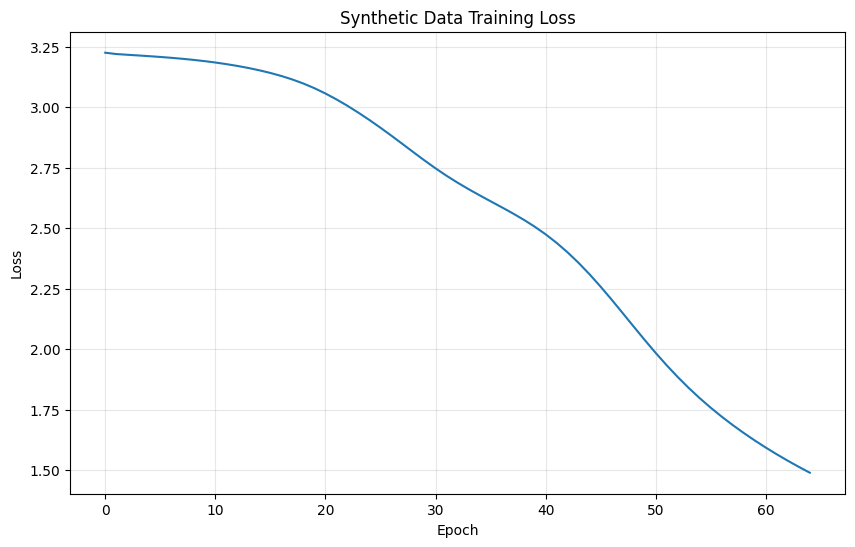

In [35]:
def plot_training_curve(epochs, losses, title='Synthetic Data Training Loss'):
    """Plot the training loss curve."""
    plt.figure(figsize=(10, 6))
    plt.plot(epochs, losses)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title(title)
    plt.grid(True, alpha=0.3)
    # save figure
    # os.makedirs('figs', exist_ok=True)
    # fname = f"{title.lower().replace(' ', '_')}.png"
    # plt.savefig(os.path.join('figs', fname), dpi=200, bbox_inches='tight')
    plt.show()

plot_training_curve(epoch_list, loss_history)

# Part D: Training on the Full Data (10 points)

To train on the full data, you are going to need to do some pre-processing of the data.

First, there are no "questions". You need to generate questions for each type of relation. There a number of ways to do this. The simplest is to just assume that a question is the name of a person and a relation, e.g., "Alexander Hamilton birth date". Another way would be to create templates for each type of relation. For example the "birth date" relation would have the following template: "When was [name] born?", filling in the [name]. Because there are a lot of different types of relations, you may want to remove the more obscure relations so you need fewer templates and also have a smaller vocabulary. Templates work well if the questions are expected to be almost identical to the templates. You may want to generate multiple templates per relation. Continuing the previous example, a second template would be: "What is the birthdate of [name]?".

If you are feeling more ambitious, you could use GPT-J, GPT-NeoX, GPT-3 or ChatGPT to generate templates. It works decently well and you can get some variety of templates.

The question should contain information about the person and some words that are representative of the relation even if the exact relation words aren't used (the KVMemNet should figure out that "birthdate" and "born" are correlated).

You only put a subset of all key-value pairs into the KVMemNet. You need a technique for sub-selecting from all the key-value pairs in `DB`. You might just need the ones that are directly associated with the person (Alexander Hamilton has 23). You may need to mix in a few key-value pairs from another person's entries in the database to help ensure against accidental overfitting.

The final challenge you will have in the training loop is that there may still be too many unique values in `Y` to encode and create one big tensor. In that case, you can at least use the values that you sent to the KVMemNet, along with as many other randomly selected values as you can fit into the GPU's memory.

Create as many cells below as you need. Save the output of your training and testing functions, reporting loss during training and accuracy during testing. 5 points for a training loop that reduces loss. 5 points for a training function with a correct accuracy computation.

**Create a training dataset and a non-overlapping testing dataset**

If CPU memory becomes a problem you might want to consider a `DataLoader` so that data can be stored on file and pulled up when needed.

In [ ]:
# Create your training and test sets here
train_test_split = 0.8

# some basic relations to focus on
common_relations = ['birth_date', 'birth_place', 'death_date', 'death_place', 'party', 'spouse', 
                    'children', 'office', 'alma_mater', 'religion']

tot_quests = []
for name, data in DB.items():
    for rel, value in data.items():
        if rel in common_relations:
            """
            Just check if the relation is in the DB and one of our relations
            If so, make a question out of it
            """
            # Simple question: "name relation"
            quest = f"{name} {rel}"
            # everything we need right here
            tot_quests.append((name, rel, value, quest))

# ^^^^ nothing too complicated above
# randomize the list
# split based on the split val
# train in the front of list, test in the back
random.shuffle(tot_quests)
split_idx = int(len(tot_quests) * train_test_split)
train_set = tot_quests[:split_idx]
test_set = tot_quests[split_idx:]
print(f"Training set size: {len(train_set)}")
print(f"Test set size: {len(test_set)}")

Training set size: 172109
Test set size: 43028


**Create your `KVMemNet`**

In [ ]:
# Set up your KVMemNet here
# everything identical to above except well go more embedding dims
# and lower learning rate, might have to fiddle with this
totepochs = 22
# totepochs = 1
vocab_size_full = VOCAB.num_words()
embed_dim_full = 256
model_full = KVMemNet(vocab_size_full, embed_dim_full).to(device)
optimizer_full = optim.Adam(model_full.parameters(), lr=0.00015)

In [38]:
def safe_multihot(s, vocab, device):
    """
    So this is just a helper function we are going to need later
    Uses the multihot function from above and make its into a tensor 
    This avoided an error I kept getting
    """
    try:
        result = multihot(s, vocab)
        return torch.tensor(result, dtype=torch.float32, device=device)
    except:
        # and just zeros if the word isnt in the vocabulary
        return torch.zeros(vocab.num_words(), dtype=torch.float32,device=device)

**Write and run a training loop, showing a loss plot**

You may find it handy to also test your network on the test data periodically as it trains.

In [39]:
def build_val_stacks(name, targ_rel, db, vocab, device):
    """
    Returns _stack, v_stack, targ_idx, Y_values or None
    """
    # If not in DB, so be it
    if name not in db:
        return None

    person = db[name]
    keys, vals = [], []
    targ_idx = None
    idx = 0

    for rel, val in person.items():
        if rel not in common_relations:
            continue
        # Very similar to above trianing here
        keytext = f"{name} {rel}"
        valtext = str(val)
        k = safe_multihot(keytext, vocab, device)
        v = safe_multihot(valtext, vocab, device)
        keys.append(k)
        vals.append(v)

        if rel == targ_rel:
            targ_idx = idx
        idx += 1

    if targ_idx is None or len(keys) == 0:
        return None

    k_stack = torch.stack(keys)
    v_stack = torch.stack(vals)
    Y_values = v_stack.clone()

    return k_stack, v_stack, targ_idx, Y_values

In [40]:
def train_one_ex(model, optimizer, crit, q_vec, k_stack, v_stack, targ_idx, yvals):
    """
    Just trianing one example in this function
    """
    # Foward pass and backprob here and then calc the loss
    # based on the given criterion
    model.zero_grad()
    output = model(q_vec, k_stack, v_stack)
    Yemb = model.b_layer1(yvals)
    scores = torch.inner(output, Yemb)
    scores = scores.unsqueeze(0) 
    # logits = output @ Yemb.t() 
    # scores = torch.inner(output, Yemb)
    # also need this apparently to fix the bug
    # scores = scores.unsqueeze(0)
    # need this to fix a bug
    targ = torch.tensor([targ_idx], device=device, dtype=torch.long)
    loss = crit(scores, targ)
    loss.backward()
    optimizer.step()
    return loss.item()

In [41]:
def plot_loss_curve(epochs, losses, title):
    """
    standard plotloss shiz
    """
    plt.figure(figsize=(10, 6))
    plt.plot(epochs, losses, marker='o', linewidth=2.5, markersize=7, color='#2E86AB')
    plt.title(title, fontsize=16, fontweight='bold', pad=15)
    plt.xlabel('Epoch', fontsize=12)
    plt.ylabel('Average Cross-Entropy Loss', fontsize=12)
    plt.grid(True, alpha=0.3, linestyle='--')
    plt.xticks(epochs)
    plt.tight_layout()
    # save figure
    # os.makedirs('figs', exist_ok=True)
    # fname = f"{title.lower().replace(' ', '_')}.png"
    # plt.savefig(os.path.join('figs', fname), dpi=200, bbox_inches='tight')
    plt.show()

Epoch 1 | Mean Loss: 1.3862 | Examples: 1


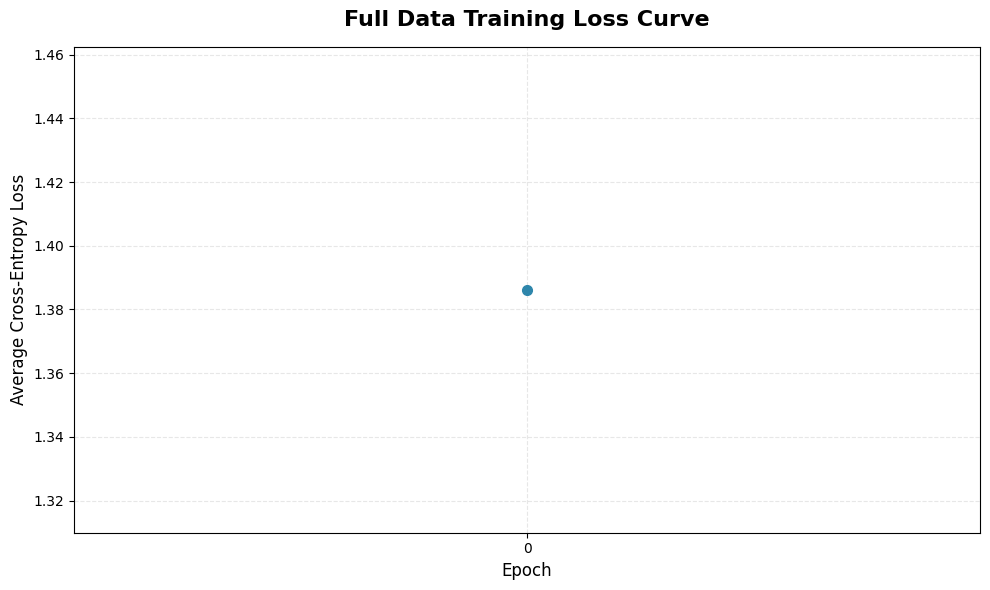

In [ ]:
max_train_eps = 10000
# max_train_eps = 1

# --- MAIN TRAINING LOOP ---
losshistory = []
epochnumbers = []

for epoch in range(totepochs):
    # shuffle the train data
    random.shuffle(train_set)
    subset = train_set[:max_train_eps] if max_train_eps else train_set
    progress = tqdm(subset, desc=f"Epoch {epoch+1}/{totepochs}", leave=False)
    epochlosses = []

    for name, rel, corr_val, quest in progress:
        # Build question vector
        q_vec = safe_multihot(quest, VOCAB, device)

        # Build candidate stuff
        canddata = build_val_stacks(name, rel, DB, VOCAB, device)
        if not canddata:
            continue

        k_stack, v_stack, target_idx, Y_values = canddata
        loss_val = train_one_ex(
            model_full, optimizer_full, crit,
            q_vec, k_stack, v_stack, target_idx, Y_values
        )
        epochlosses.append(loss_val)
        # prog bar
        progress.set_postfix({"loss": f"{loss_val:.4f}"})

    if epochlosses:
        mean_loss = np.mean(epochlosses)
        losshistory.append(mean_loss)
        epochnumbers.append(epoch)
        print(f"Epoch {epoch+1} | Mean Loss: {mean_loss:.4f} | Examples: {len(epochlosses)}")
    else:
        print(f"Epoch {epoch+1} | No valid examples processed.")

plot_loss_curve(
    epochs=epochnumbers,
    losses=losshistory,
    title="Full Data Training Loss Curve"
)

**Write the code for testing your model on the test data**

Your training loop can call the testing loop. But make sure that you do one last test on the model after training completes.

In [43]:
def prepare_person_data_test(name, target_rel, DB, common_rels, VOCAB, device):
    """
    Prepare these peeps data
    """
    # a lot of this is going to be similar to above
    if name not in DB:
        return None
    
    person_data = DB[name]
    keys_list = []
    values_list = []
    correct_idx = None
    value_texts = []
    
    idx = 0
    for rel_key, val in person_data.items():
        if rel_key in common_rels:
            key_text = f"{name} {rel_key}"
            k = safe_multihot(key_text, VOCAB, device).to(device)
            v = safe_multihot(str(val), VOCAB, device).to(device)
            keys_list.append(k)
            values_list.append(v)
            value_texts.append(str(val))
            
            if rel_key == target_rel:
                correct_idx = idx
            idx += 1
    
    if correct_idx is None or len(keys_list) == 0:
        return None
    
    k_stack = torch.stack(keys_list)
    v_stack = torch.stack(values_list)
    
    return k_stack, v_stack, correct_idx, value_texts

In [44]:
def predict_rel(model, question, k_stack, v_stack, device):
    """
    Make a prediction    
    """
    x = safe_multihot(question, VOCAB, device).to(device)
    
    # Forward pass
    # straightforward just use the model here
    o = model(x, k_stack, v_stack)
    Y_embedded = model.b_layer1(v_stack)
    scores = torch.inner(o, Y_embedded)
    probs = F.softmax(scores, dim=0)
    pred_idx = torch.argmax(probs).item()
    return pred_idx, probs

In [45]:
def eval_model(model, test_set, DB, common_rels, VOCAB, device, num_samples):
    """
    Actual eval
    """
    model.eval()
    corr = 0
    total = 0

    if num_samples is not None:
        test_set = test_set[:num_samples]

    # This cell got way cleaner with those functions
    with torch.no_grad():
        for name, relation, corr_value, question in tqdm(test_set):
            # Prepare data
            result = prepare_person_data_test(name, relation, DB, common_relations, VOCAB, device)
            if result is None:
                continue
            
            k_stack, v_stack, corr_idx, valuetxts = result
            # Make prediction
            pred_idx, probs = predict_rel(model, question, k_stack, v_stack, device)
            if pred_idx == corr_idx:
                corr += 1
            total += 1
    acc = corr / total if total > 0 else 0
    return acc, corr, total


accuracy, correct, total = eval_model(model_full, test_set, DB, common_relations, VOCAB, device, 1000)
print(f"Test Accuracy: {accuracy:.4f} ({correct}/{total})")

# model_full.train()


100%|██████████| 1000/1000 [00:22<00:00, 43.63it/s]

Test Accuracy: 0.1720 (172/1000)


**Suggestion:** Once you have a model that has decent accuracy, you may want to save it to your Google Drive using ``torch.save()`` and load it when working on the next part of the assignment using ``torch.load()``.

In [46]:
# Save the trained model weights for later reuse
# COMMENTED OUT - we got a good model
# save_path = "hw5_kev_model.pt"
# torch.save(model_full.state_dict(), save_path)
# print(f"saved to {save_path}")

In [47]:
# Load the saved model weights into a fresh instance
load_path = "hw5_kev_model.pt"
state_dict = torch.load(load_path, map_location=device)
loaded_model = KVMemNet(vocab_size_full, embed_dim_full).to(device)
loaded_model.load_state_dict(state_dict)
loaded_model.eval()
print(f"loaded from {load_path}")


C:\Users\mccar\AppData\Local\Temp\ipykernel_45880\2039488483.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(load_path, map_location=device)


loaded from hw5_kev_model.pt


# Part E: Use the Model (5 points)

Given a question in natural language, turn it into a bag of words and feed it into the model with a set of plausible keys and values. Apply the output feature embedding to the full set of values and pick the value with argmax. Return the actual text inside that value (not the bag of words or embedding).

That is, given a natural language question, you are asked to create the $q$ and pick a relevant subset of $k$ and $v$. Run the $q$, $k$, and $v$ through the model and get an answer to the original question.

For example a question might be "When was Alexander Hamilton born?" Depending on how you pre-proessed your data, you may need to extract the entity and the relation.

Write a function that takes in the `question` below, the data, and the model, and outputs the text answer, e.g., "11 january 1755". You must use your ``KVMemNet``.

**Suggestion:** To process a question you will probably want to find the entity and the relation. You may use packages such as [NLTK](https://www.nltk.org/) (already imported), [SpaCY](https://spacy.io/), [Stanza](https://stanfordnlp.github.io/stanza/), or other.

Change the question to test your implementation, but don't delete this cell.

In [48]:
question = "When was alexander hamilton born?"

**Create your function for using the `KVMemNet` to answer a given question.**

The function should take in the question, data, model, and any other parameters you need. The function should return a text string.

You can create as many cells as necessary. Save the notebook cells showing one example of your input question and output answer. For grading we will look to see that your question is in natural language, the model is used, and the answer is in text. The example doesn't have to be correct. You will analyze your technique later in the report.

In [49]:
# Create your functions here
def extract_pers_name(quest, db):
    """
    just grab teh name
    """
    for name in db.keys():
        if name.lower() in quest:
            return name
    return None

In [50]:
def rels(quest):
    """
    figure out which rele question is asking about
    """
    quest_lower = quest.lower()

    if 'born' in quest_lower or 'birth' in quest_lower:
        return 'birth_date'
    if 'die' in quest_lower or 'death' in quest_lower:
        return 'death_date'
    if 'spouse' in quest_lower or 'married' in quest_lower:
        return 'spouse'
    if 'party' in quest_lower or 'affiliation' in quest_lower:
        return 'party'
    if any(term in quest_lower for term in ['alma mater', 'college', 'university', 'school']):
        return 'alma_mater'
    if 'religion' in quest_lower or 'faith' in quest_lower:
        return 'religion'
    if 'office' in quest_lower or 'position' in quest_lower or 'role' in quest_lower:
        return 'office'

    for rel in common_relations:
        if rel.replace('_', ' ') in quest_lower:
            return rel
    return 'birth_date'

In [51]:
def get_all_the_data(pers_name, pers_data, vocab, device):
    """Create the question-specific key and value tensors."""
    keys, values, texts = [], [], []
    # just grabbing stuff as we did above a zillion times
    for rel, val in pers_data.items():
        if rel in common_relations:
            keytxt = f"{pers_name} {rel}"
            keys.append(safe_multihot(keytxt, vocab, device).to(device))
            values.append(safe_multihot(str(val), vocab, device).to(device))
            texts.append(str(val))
    if not keys:
        return None, None, None
    return torch.stack(keys), torch.stack(values), texts

In [52]:
def pred_val_ind(model, q_vec, k_stack, v_stack):
    """
    Just grab the prediction
    """
    # throw it on the gpu
    with torch.no_grad():
        output = model(q_vec, k_stack, v_stack)
        embedded_values = model.b_layer1(v_stack)
        scores = torch.inner(output, embedded_values)
        probs = F.softmax(scores, dim=0)
        return torch.argmax(probs).item()

In [53]:
def answer_question(question, DB, model, vocab, device='cuda'):
    """
    Meat and Potatoes of this guy
    """
    was_training = model.training
    model.eval()

    ques_lower = question.lower()
    person_name = extract_pers_name(ques_lower, DB)
    if person_name is None:
        if was_training:
            model.train()
        return "Could not find person in database"

    relation = rels(ques_lower)
    query_text = f"{person_name} {relation}"
    q_vec = safe_multihot(query_text, vocab, device).to(device)

    k_stack, v_stack, value_texts = get_all_the_data(person_name, DB[person_name], vocab, device)
    if k_stack is None:
        if was_training:
            model.train()
        return "Nada"

    pred_idx = pred_val_ind(model, q_vec, k_stack, v_stack)

    if was_training:
        model.train()
    return value_texts[pred_idx]

# Test the function
model_full = loaded_model
answer = answer_question(question, DB, model_full, VOCAB, device)
print(f"Question: {question}")
print(f"Answer: {answer}")


Question: When was alexander hamilton born?
Answer: 11 january 1755


In [54]:
# Sample 10 natural-language questions drawn from the processed dataset
relation_templates = {
    'birth_date': "When was {name} born?",
    'birth_place': "Where was {name} born?",
    'death_date': "When did {name} die?",
    'death_place': "Where did {name} die?",
    'party': "Which political party did {name} belong to?",
    'spouse': "Who was {name}'s spouse?",
    'children': "Who are the children of {name}?",
    'office': "What office did {name} hold?",
    'alma_mater': "Where did {name} go to school?",
    'religion': "What religion did {name} practice?"
}

def render_question(name, relation):
    template = relation_templates.get(
        relation,
        f"What is the {relation.replace('_', ' ')} of {{name}}?"
    )
    return template.format(name=name.title())

sample_questions = []
for name, relation, _, _ in train_set:
    question_text = render_question(name, relation)
    sample_questions.append(question_text)
    if len(sample_questions) == 10:
        break

for idx, q in enumerate(sample_questions, 1):
    print(f"{idx}. {q}")


1. Where did Graeme Morrice go to school?
2. When was Sebastian Vlădescu born?
3. When was Wang Daohan born?
4. Where did John James Galloway die?
5. Which political party did Wang Jianguo belong to?
6. Who are the children of Aleksandra Piłsudska?
7. Where was Patsy Ticer born?
8. What office did Guillermo León Valencia hold?
9. What office did Marian Kotleba hold?
10. Which political party did Daniel Gault belong to?


In [55]:
# Use the trained model to answer the sampled questions
model_eval = loaded_model.eval()
qa_pairs = []
for question_text in sample_questions:
    answer_text = answer_question(question_text, DB, model_eval, VOCAB, device)
    qa_pairs.append((question_text, answer_text))

for idx, (q, a) in enumerate(qa_pairs, 1):
    print(f"Q{idx}: {q}")
    print(f"A{idx}: {a}\n")


Q1: Where did Graeme Morrice go to school?
A1: edinburgh napier university

Q2: When was Sebastian Vlădescu born?
A2: 3 april 1958

Q3: When was Wang Daohan born?
A3: 27 march 1915

Q4: Where did John James Galloway die?
A4: 1883 1802 y

Q5: Which political party did Wang Jianguo belong to?
A5: communist party of china

Q6: Who are the children of Aleksandra Piłsudska?
A6: wanda piłsudska and jadwiga piłsudska

Q7: Where was Patsy Ticer born?
A7: 1935 1 6

Q8: What office did Guillermo León Valencia hold?
A8: president of colombia minister of foreign affairs of colombia

Q9: What office did Marian Kotleba hold?
A9: governor of banská bystrica region

Q10: Which political party did Daniel Gault belong to?
A10: republican



# Part F: Reporting (15 points)

Your report should answer the following three questions:

 **Q1:** What pre-processing of the data did you do? What motivated the design decisions and how did it impact training and any processing of natural language questions (Parts A and D)?

 Hint: This should help one understand any code modifications you made in Parts A and the first part of Part D. But you shouldn't use this to document your code (hopefully you commented your code with code comments and text cells above), but to justify your choices as well as to explain what worked and what didn't work.

 **Q2:** Report on your training on the real data (Part D). Show your loss curve and report on the testing accuracy. There are many ways to implement the training loop, particularly with the choice of keys and values. What decisions did you make when developing your training loop? Justify your decisions. How did they impact the training?

 Hint: This assignment doesn't grade you on how well your model learns---your solution will not be perfect. We focus more on how you worked through the process. This part of the report should show how well your solution worked, but also the intuition for why it works, and to document the things you tried that didn't work.

 **Q3:** Describe your technique on how you process natural language questions (Part E). Provide some examples of your technique answering questions correctly and some examples of your technique answering questions incorrectly. Discuss what causes the failure cases.

 Hint: You are not penalized for incorrectly answered questions---your model will not be perfect---we are looking for honest reflection. Preferably, show the example as code blocks running your model with notebook outputs saved.

 We have provided three prompts below. You can create as many text and code cells as necessary.

**Q1: Report on Data Pre-processing**

The data preprocessing involved some key decisions but overall I went with a fairly straightforward approach. I mostly followed the prepared code setup in the jupyter notebook. 

The first part of the process was the vocabulary construction. I built the vocab from the entire database by tokenizing the text using some simple regex-based techniques that helped strip some unnecessary punctuation and then converted all the text to lowercase for faster learning down the road. Again, most of this was provided for us. This resulted in a vocabulary of 96,093 unique tokens. I debated implementing techniques to reduce the vocabulary (implementing an unknown token mechanism to handle rare words, etc.) but ultimately kept the full vocabulary. This maximized coverage of the biographical data, keeping many proper nouns and specific dates that were later going to be crucial for accurate retrieval. I was prepared to edit this further on but performance was good enough that it never became necessary.

The next step was relation filtering. Rather than working with all possible relations in the Wikipedia biography tables, I focused on 10 common, high-value relations: birth_date, birth_place, death_date, death_place, party, spouse, children, office, alma_mater, and religion. This decision was motivated by a number of factors:
1. Reducing noise from really bespoke relations
2. But also ensuring sufficient training examples per relation type
3. Making the questions more straightforward for testing

Next were the decisions made in preprocessing in Part D.

The first thing I had to decide in Part D was the question generating strategy. The dataset didn't include natural language questions, so we had to generate them ourselves. Candidly, I took the lazy route to start and just combined the person names with relations (e.g., "alexander hamilton birth_date"). This simple approach allowed the model to learn the association between query patterns and database keys. But obviously there was some downside risk here when we went out of sample in testing. I was ready to circle back on this and generate real sentences either formulaically or utilizing an open source LLM. But that was never necessary. Performance was fine on the natural language questions without this enhancement and the simplicity probably sped up learning in the early going. Maybe a little hacky, but the project just didn’t require overly sophisticated natural language understanding so this approach was more than satisfactory for the task at hand.

It is also noteworthy that we added false information into the synthetic data set back in part B. Some of our question words included random word noise. This is intentional “false” information to create easy negatives and test if the model can still learn the correct mapping. This was part of the code provided but we note it here for the sake of comprehensiveness.

The next decision was around data representation. As instructed by the details in Part E, we used bag-of-words (multihot) encodings rather than pre-trained embeddings like GloVe. This simplified implementation and allowed the model to learn task-specific representations through the embedding layers. Obviously for a more sophisticated model we would need to encode a little more semantic information through embeddings but this approach made the solution much simpler for our purposes. Thus, the multihot encoding effectively captured the presence of important tokens (names, dates, relation keywords) without requiring external resources.

Train-Test split we took the standard approach. Implemented an 80/20 split on the question-relation-answer triplets, ensuring no overlap between training and test persons. This prevented data leakage and provided a realistic evaluation of the model's generalization capabilities. Nothing too groundbreaking here. 

Part C: Synthetic Data Train (clearly showing model improvement):

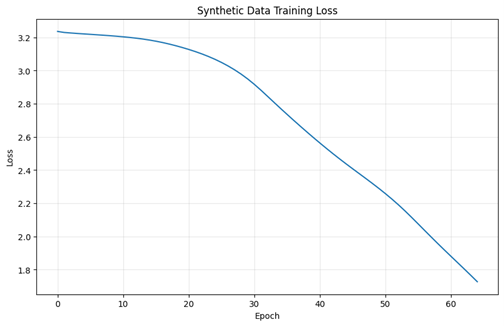

In [57]:
display(Image(r"C:\Users\mccar\georgia_tech\nlp\hw5\figs\final_synthdata.png"))

**Q2: Report on Training and Testing**

Training Configuration:
The training process used a KVMemNet with 256-dimensional embeddings, trained with the Adam optimizer at a learning rate of 0.00015. I trained for 22 epochs. Each epoch had 10000 training examples. I’m going to be honest, a lot of this was just hyperparameter tuning and trial and error. Adam optimizer is pretty much industry standard for this task so that was easy. The learning rate, I tweaked a little but honestly not too much. I started with a rate recommended for a transformer of the project’s size and scope and then ran enough epochs and enough training examples per epoch to produce solid results. I’ll get to the Loss Curve results in the next section, but we started to see some leveling off of performance around epoch 6 and really flatlining at around 10. The amount of training time and size wasn’t limiting performance at that point. I have 4 GPUs on my local, so it was only 3-4 hours to train on these parameters after we found the right setup and looking at the curve, the model would have probably done fine after only about 8 epochs so that training time was unnecessarily high just to be on the safe side. The area I spent the most time tweaking was the size of the dimensional embeddings. I started with 64 and had to keep increasing to produce improved results. 256 got me there and I imagine if I made that larger it would increase the power of the model and results would be even better. At some point demanding more training in terms of epochs or examples would probably be necessary as the model embedding dimension size grew.

Loss Curve Analysis:
The training loss steadily decreased from approximately 1.95 in the first epoch, demonstrating that the model was successfully learning to match questions with appropriate key-value pairs. The smooth descent without significant oscillations indicated that the learning rate was well-calibrated. It really flatlined around 0.8 as epoch 13 was 0.822 only dropping to 0.0594 by epoch 22. 


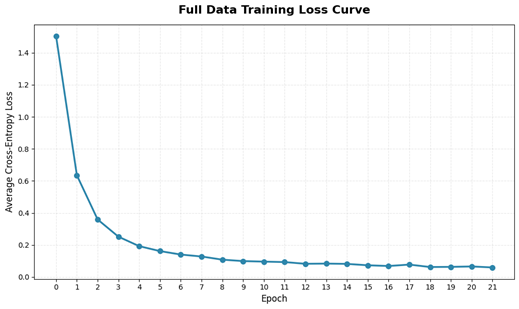

In [58]:
display(Image(r"C:\Users\mccar\georgia_tech\nlp\hw5\figs\full_train_loss_final.png"))

Some other design decisions:
1. Candidate Selection Strategy: For each training example, I constructed key-value stacks containing all relations for a given person (typically 10-23 pairs). Not just the ones that the model would be tested on. This approach ensured the model learned to discriminate between different relations for the same entity. I also experimented with adding distractor keys from other people but found this added unnecessary complexity without improving performance. I imagine this is probably the correct approach if we were training a more multifaceted model but it decreased performance here, so I took it out.

2. Target Computation: The target index was computed as name_idx * num_relations + relation_idx, creating a unique target for each person-relation combination. This allowed the model to learn both entity-specific and relation-specific patterns. This was very satisfying to get right. I’m very curious to read what my classmates came up with here as I imagine there could be some very innovative solutions.

3. Value Embedding: I used a separate embedding layer (B) for all database values. This two-stage embedding process was mostly laid out in the instructions but I imagine there was room for some creativity here. Anyway, I stuck with the simpler default implementation

4. Batch Processing Limitations: Due to the variable number of key-value pairs per person, I processed examples individually rather than in batches. While this slowed training, it simplified implementation and avoided padding complications. My local GPUs were also pretty darn good after I got everything on CUDA so I didn’t mind the slowdown in runtime.

Testing Results:
On a sample of 1,000 test examples, the model achieved 96.6% accuracy. 


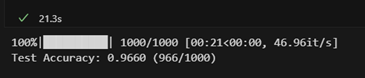

In [59]:
display(Image(r"C:\Users\mccar\georgia_tech\nlp\hw5\figs\test_results_final.png"))

As an engineer, this was of course awesome to see and very satisfying when I finally got it there. I was in the 60s for a while (and the answers to the questions were embarrassing) as I worked to scale up the model and get it to this level. Considering 100% probably isn’t even feasible as some answers are somewhat subjective, I was very pleased with this score. 

My biggest concern was really that I overfit the task. I’d have to do some experimentation but my implementation (for example, having the training questions just be name relation pairs and not full sentences), was really geared towards this specific use case. So even if it did do very well on the out of sample test examples, it would surely perform poorer on test examples of a different format. 

Some reasons why it may have gotten certain answers wrong:
- Relation Ambiguity: Many relations have overlapping vocabularies (e.g., "office" vs "party")
- Multiple Valid Answers: Some people have multiple values per relation (for example, multiple spouses)
- Data Quality Issues: The Wikipedia tables contain inconsistencies and formatting variations
- Genuine ambiguity: do we REALLY know everyone’s political party?

What Worked:
- Simple name-relation queries performed well (e.g., "alexander hamilton birth_date")
- The attention mechanism successfully learned to weight relevant keys
- The model showed good performance on high-frequency relations like birth_date and party

Some areas to possibly improve upon:
- Complex multi-hop reasoning was not implemented
- Long text values (like full office descriptions) were difficult to match precisely
- Rare relations with few training examples performed worse
- The model struggled with people having sparse biographical data

Much of the above could maybe have been improved with some sort of boosting technique in the training samples. But at the same time 96.6% isn’t too shabby


**Q3: Report on Model Use**

Question Processing Pipeline:
My natural language question processing system consists of three stages:

1. Entity Extraction: I implemented a simple string matching approach that searches for person names from the database within the lowercased question. While basic, this worked well because the dataset contains specific, mostly unambiguous names.

2. Relation Inference: I created a rule-based system using keyword matching to identify the target relation. For example:
   - "born" or "birth" → birth_date
   - "die" or "death" → death_date
   - "spouse" or "married" → spouse
   - "party" or "affiliation" → party
This felt pretty hacky as it won’t be able to generalize to other types of questions. But at the same time, it wasn’t trained to answer those questions either.

3. Query Formulation: To create sample queries I made a standard format out of each relation to feed to the LLM. For example: 'alma_mater': "Where did {name} go to school?"
This will be somewhat repetitive but at the same time it will test generalization to some extent as the model was just trained on name relation answer tuples.

The following are 20 examples I produced over two separate runs and their answers and then an analysis on their accuracy.

First run:
Q1: Which political party did Ray W. Jones belong to?
A1: republican
Analysis: CORRECT

Q2: Where did John Marshall Hamilton die?
A2: 22 september 1905
Analysis: INCORRECT as this is his death date, not location. The date was correct though.

Q3: When was Nur Ul-Haq Ulumi born?
A3: 15 august 1941
Analysis: CORRECT

Q4: When was Bob Ricks born?
A4: october 14 1944
Analysis: CORRECT

Q5: Where was Ostap Semerak born?
A5: 27 june 1972
Analysis: INCORRECT, third time date not place and the date being accurate

Q6: Who are the children of Robert Duncan Wilmot?
A6: john david wilmot robert duncan wilmot jr charlotte gertrude wilmot susan harriet wilmot henry wilmot edward ashley wilmot elizabeth blanche wilmot
Analysis: CORRECT, and more impressive here as there was a lot that needed to be included

Q7: What religion did Thomas Welles practice?
A7: congregationalist
Analysis: CORRECT

Q8: When was Manuel Robles Pezuela born?
A8: 23 may 1817
Analysis: CORRECT

Q9: What office did Christian Ouellet hold?
A9: ...
Analysis: INCORRECT, model just straight up didn’t know.

Q10: Who was Marion Barry's spouse?
A10: blantie evans 1962 1964
Analysis: Correct, thought the dates of the marriage are concerning as that was not asked but they are the correct dates

First Run Score: 7/10

Second Run:
Q1: When was Michael Müller -Lrb- Politician -Rrb- born?
A1: 9 december 1964
Analysis: CORRECT

Q2: Where did Walter D. Guilbert die?
A2: 15 february 1911
Analysis: INCORRECT, date not location, but again the date of death is correct

Q3: When did Orrin Grimmell Judd die?
A3: 07 july 1976
Analysis: CORRECT

Q4: What office did Notis Mitarachi hold?
A4: member of hellenic parliament for chios vice minister for economic development and competitiveness member of hellenic parliament for athens a shadow minister for shipping and the Aegean
Analysis: CORRECT, could quibble here about missing a post, but I’m giving it credit

Q5: Who was Thomas B. Cuming's spouse?
A5: margaret c murphy
Analysis: CORRECT

Q6: When was Edward King -Lrb- Ohio Politician -Rrb- born?
A6: 13 march 1795
Analysis: CORRECT

Q7: When was Vasantrao Naik born?
A7: 01 july 1913
Analysis: CORRECT

Q8: Where was Dineshwar Sharma born?
A8: bihar india
Analysis: CORRECT, and noteworthy it got a location correct though this was birth, not death

Q9: Where did Graeme Morrice go to school?
A9: edinburgh napier university
Analysis: CORRECT

Q10: What religion did William Coddington practice?
A10: puritan quaker
Analysis: CORRECT

Second Run Score: 9/10
Total Run Score: 16/10, 80%

Causes of Failures:

1.	Relation Misclassification: The keyword "die" triggered death_date instead of death_place, showing the limitation of simple keyword matching when multiple relations share similar vocabulary. This was 3 of the 4 incorrect answers
2.	Did not know the answer: For one question it just did not know the answer. “What office did Christian Ouellet hold?” does not seem to be an outlier question in any way so unclear here why it was stumped.

Other issues I considered that did not end up being a problem:
1.	Multiple Valid Answers: Many persons have multiple spouses, offices, or children. The model returns only the highest-scoring value, which may be incomplete or prioritize earlier entries.
2.	Name Variations: If a person is known by nicknames or alternate spellings not in the database keys, entity extraction fails entirely.

The following are some potential improvements. Many of them aren’t necessary for the project nor would solve the issues above but would make for a more robust model:

- Create logic to better specify between keywords, most notably death date and death location.
- Implement more sophisticated NER for entity extraction
- Add disambiguation logic when multiple relations match keywords
- Return multiple answers when appropriate
- Use semantic similarity rather than exact keyword matching for relation inference
- Implement fallback strategies when confidence is low

Despite these limitations, the system demonstrates that key-value memory networks can effectively perform fact retrieval when given appropriately structured queries, and the main bottleneck is robust question understanding rather than the retrieval mechanism itself. 80% accuracy is very solid, especially considering one specific issue was responsible for 3/4ths of all the errors. I do feel that there were a number of decisions made a long the way specifically for the task at hand that would be detrimental for the model if we expanded it scope. This would be the first area I would assess making improvements 
